# Tutorial: Brd4 bindings for Male/Female mouse bulk calling cards data. 

 We will analyze bulk calling cards datasets from [Kfoury et al., PNAS. (2021)](https://www.pnas.org/doi/10.1073/pnas.2017148118), which can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156821). These experiments were designed to study differences in Brd4 binding between male and female cells in a genetically engineered cellular model of glioblastoma (GBM). These nearly-isogenic cells were derived from murine neocortical postnatal day 1 (p1) astrocytes (male and female GBM astrocytes) and were engineered to contain a combined loss of neurofibromin (NF1) and p53 function. These cells were previously shown to display sex differences in important GBM  phenotypes in vivo, including proliferation, clonogenic stem-like frequency, in vivo tumorigenesis, cell cycle regulation, gene expression, and chemotherapy response, that mimic those observed in GBM patients. For more details see [Kfoury et al., PNAS. (2021)].

 In this tutorial, we will call peaks, annotate these peaks, perform differential peak analysis, and pair differentially bound genomic regions with nearby genes that are also differentially expressed between the sexes. There are 668525 insertions in female qbed data and 613728 insertions in male qbed data. For bulk RNA-seq data, there are 6 samples in total: 3 female samples and 3 male samples. It creates a group by peak anndata for calling cards data. If you want to create a replicate by peak anndata only, please check [Github](https://github.com/The-Mitra-Lab/pycallingcards_data/blob/main/Brd4_bulk-replicate.ipynb)

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150

We start by reading qbed data. In these data, each row provides information about one Brd4-directed insertion organized into columns to indicate the chromosome, start point, end point, number of reads supporting the insertion, and the orientation and barcode for each insertion. For example, in the file displayed below, the first row tells us that the first insertion occured into a TTAA on Chromosome 1, whose coordinates start location 3478112 and end at 3478115. There was 1 read supporting this insertion and the transposon is orientated so that the plus strand of the transposon is on the plus strand of the genome. The transposon barcode is TTTGTCCAA. We add another column indecating its respected group. 

Use ```cc.rd.read_qbed(filename)``` to load your own qbed data.

In [2]:
Female_Brd4 = cc.datasets.mouse_brd4_data(data = "Female_Brd4")
Female_Brd4['group'] = "Female_Brd4"
Female_Brd4
#load female CC data

Chr     Start       End  Reads Direction   Barcodes        group
0        chr1   3478111   3478115      1         +  TTTGTCCAA  Female_Brd4
1        chr1   3481743   3481747      1         +  TATGTACAA  Female_Brd4
2        chr1   3481957   3481961      1         -  TATGTACAA  Female_Brd4
3        chr1   3493161   3493165     16         +  TATGTACAA  Female_Brd4
4        chr1   3493702   3493706      1         +  CGTTACACA  Female_Brd4
...       ...       ...       ...    ...       ...        ...          ...
1290214  chrY  90802841  90802845      1         -  CGTTACACA  Female_Brd4
1290215  chrY  90803579  90803583      1         -  TATGTACAA  Female_Brd4
1290216  chrY  90803579  90803583      1         -  TGTCGTGCA  Female_Brd4
1290217  chrY  90804429  90804433      1         -  TATACTCTA  Female_Brd4
1290218  chrY  90805130  90805134      1         -  GACGGCTCC  Female_Brd4

[1290219 rows x 7 columns]

In [3]:
Male_Brd4 = cc.datasets.mouse_brd4_data(data = "Male_Brd4")
Male_Brd4['group'] = "Male_Brd4"
Male_Brd4
#load male CC data

Chr     Start       End  Reads Direction   Barcodes      group
0        chr1   3493161   3493165      1         -  GAGGTACAG  Male_Brd4
1        chr1   3493275   3493279      1         +  TACTTTCCG  Male_Brd4
2        chr1   3493341   3493345      2         +  AGCACAGTG  Male_Brd4
3        chr1   3493341   3493345     10         +  TGTCCATTG  Male_Brd4
4        chr1   3493341   3493345      8         +  ATGAAAGCA  Male_Brd4
...       ...       ...       ...    ...       ...        ...        ...
1185697  chrY  90803733  90803737     13         -  TACTTTCCG  Male_Brd4
1185698  chrY  90803733  90803737      9         -  CACGGCGGA  Male_Brd4
1185699  chrY  90803733  90803737     17         -  GATCTTATG  Male_Brd4
1185700  chrY  90803774  90803778      4         -  ATGAAAGCA  Male_Brd4
1185701  chrY  90806562  90806566      1         -  AGCACAGTG  Male_Brd4

[1185702 rows x 7 columns]

Since we are interested in differential peak calling, we now combine the two datasets to call peaks on the joint dataset:

In [4]:
Brd4 = cc.rd.combine_qbed([Female_Brd4, Male_Brd4])
Brd4

Chr     Start       End  Reads Direction   Barcodes        group
0        chr1   3478111   3478115      1         +  TTTGTCCAA  Female_Brd4
1        chr1   3481743   3481747      1         +  TATGTACAA  Female_Brd4
2        chr1   3481957   3481961      1         -  TATGTACAA  Female_Brd4
3        chr1   3493161   3493165     16         +  TATGTACAA  Female_Brd4
4        chr1   3493161   3493165      1         -  GAGGTACAG    Male_Brd4
...       ...       ...       ...    ...       ...        ...          ...
2475916  chrY  90803733  90803737     17         -  GATCTTATG    Male_Brd4
2475917  chrY  90803774  90803778      4         -  ATGAAAGCA    Male_Brd4
2475918  chrY  90804429  90804433      1         -  TATACTCTA  Female_Brd4
2475919  chrY  90805130  90805134      1         -  GACGGCTCC  Female_Brd4
2475920  chrY  90806562  90806566      1         -  AGCACAGTG    Male_Brd4

[2475921 rows x 7 columns]

Optional: filter the insertions with reads greater than 2. Because we use strict quality control on read insertions, even insertions supported by 1 read are likely to be bona fide.

In [5]:
Brd4 = Brd4[Brd4['Reads'] > 2]
Brd4

Chr     Start       End  Reads Direction   Barcodes        group
3        chr1   3493161   3493165     16         +  TATGTACAA  Female_Brd4
7        chr1   3493341   3493345     10         +  TGTCCATTG    Male_Brd4
8        chr1   3493341   3493345      8         +  ATGAAAGCA    Male_Brd4
10       chr1   3493643   3493647      3         +  TCTACTGCC    Male_Brd4
17       chr1   3514553   3514557      7         +  TACTTTCCG    Male_Brd4
...       ...       ...       ...    ...       ...        ...          ...
2475905  chrY  42512546  42512550      3         -  ACGCGCTGT    Male_Brd4
2475914  chrY  90803733  90803737     13         -  TACTTTCCG    Male_Brd4
2475915  chrY  90803733  90803737      9         -  CACGGCGGA    Male_Brd4
2475916  chrY  90803733  90803737     17         -  GATCTTATG    Male_Brd4
2475917  chrY  90803774  90803778      4         -  ATGAAAGCA    Male_Brd4

[1229664 rows x 7 columns]

Because insertions are discrete, we now need to call peaks to deduce potential binding sites. Three different methods (*CCcaller, MACCs, Blockify*) are available along with three different species (*hg38, mm10, sacCer3*). 

In this setting, we use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*. It controls the maximum distance between two nearby insertions, or in another words, the minimum distance between two peaks. We recommend using a value between 800-1200 to set *maxbetween*.  *pvalue_cutoff* is also an important parameter and a number 0.0001-0.01 is strongly advised. The setting of *pseudocounts* is largely influenced by library size. For the first time of trial, it can be adjusted to $10^{6}-10^{-5} \times$ the number of insertions.

In [6]:
peak_data = cc.pp.call_peaks(Brd4, method = "CCcaller", reference = "mm10", pvalue_cutoff = 0.01, 
                             maxbetween = 1100, lam_win_size = 1000000, pseudocounts = 0.1, 
                             record = True, save = "peak.bed")
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


Chr      Start        End  Experiment Insertions  \
0      chr1    4196775    4198714                     16   
1      chr1    4785068    4786551                     17   
2      chr1    4806673    4807730                     21   
3      chr1    4856928    4862019                    104   
4      chr1    4912814    4916593                      7   
...     ...        ...        ...                    ...   
24546  chrX  169936677  169937745                      7   
24547  chrY     897430     899700                     11   
24548  chrY    1009018    1011799                     27   
24549  chrY    1243715    1246316                     24   
24550  chrY    1282482    1287504                     19   

       Reference Insertions  Expected Insertions        pvalue    pvalue_adj  
0                        12             0.142389  0.000000e+00  0.000000e+00  
1                        15             0.572576  0.000000e+00  0.000000e+00  
2                        12             0.477937  0.000000e+00  0.000000e+00  
3                        44             1.490080  0.000000e+00  0.000000e+00  
4                        22             0.791756  1.900897e-06  1.024407e-04  
...                     ...                  ...           ...           ...  
24546                     8             1.189526  3.479200e-05  1.673495e-03  
24547                    24             0.528165  6.046275e-13  5.162843e-11  
24548                    25             0.489073  0.000000e+00  0.000000e+00  
24549                    29             0.504932  0.000000e+00  0.000000e+00  
24550                    60             0.945958  0.000000e+00  0.000000e+00  

[24551 rows x 8 columns]


In order to tune parameters for peak calling, we advise looking at the data and evaluating the validity of the called peaks. The default settings are what we recommend, but for some TFs adjacent peaks may be merged that should not be, or, alternatively, peaks that should be joined may be called separately. 

Below, we plot the combined calling card data in males and females for a region in chromosome 1. The top track displays insertion locations and their read counts. Each dot is an insertion and the height is log(reads+1). The middle track plots the insertion density. The thrid track represents the reference genes and peaks. Finally, the last track represents peak calls.  Below you can see that regions with high densities of insertions are accurately called as Brd4 binding sites.

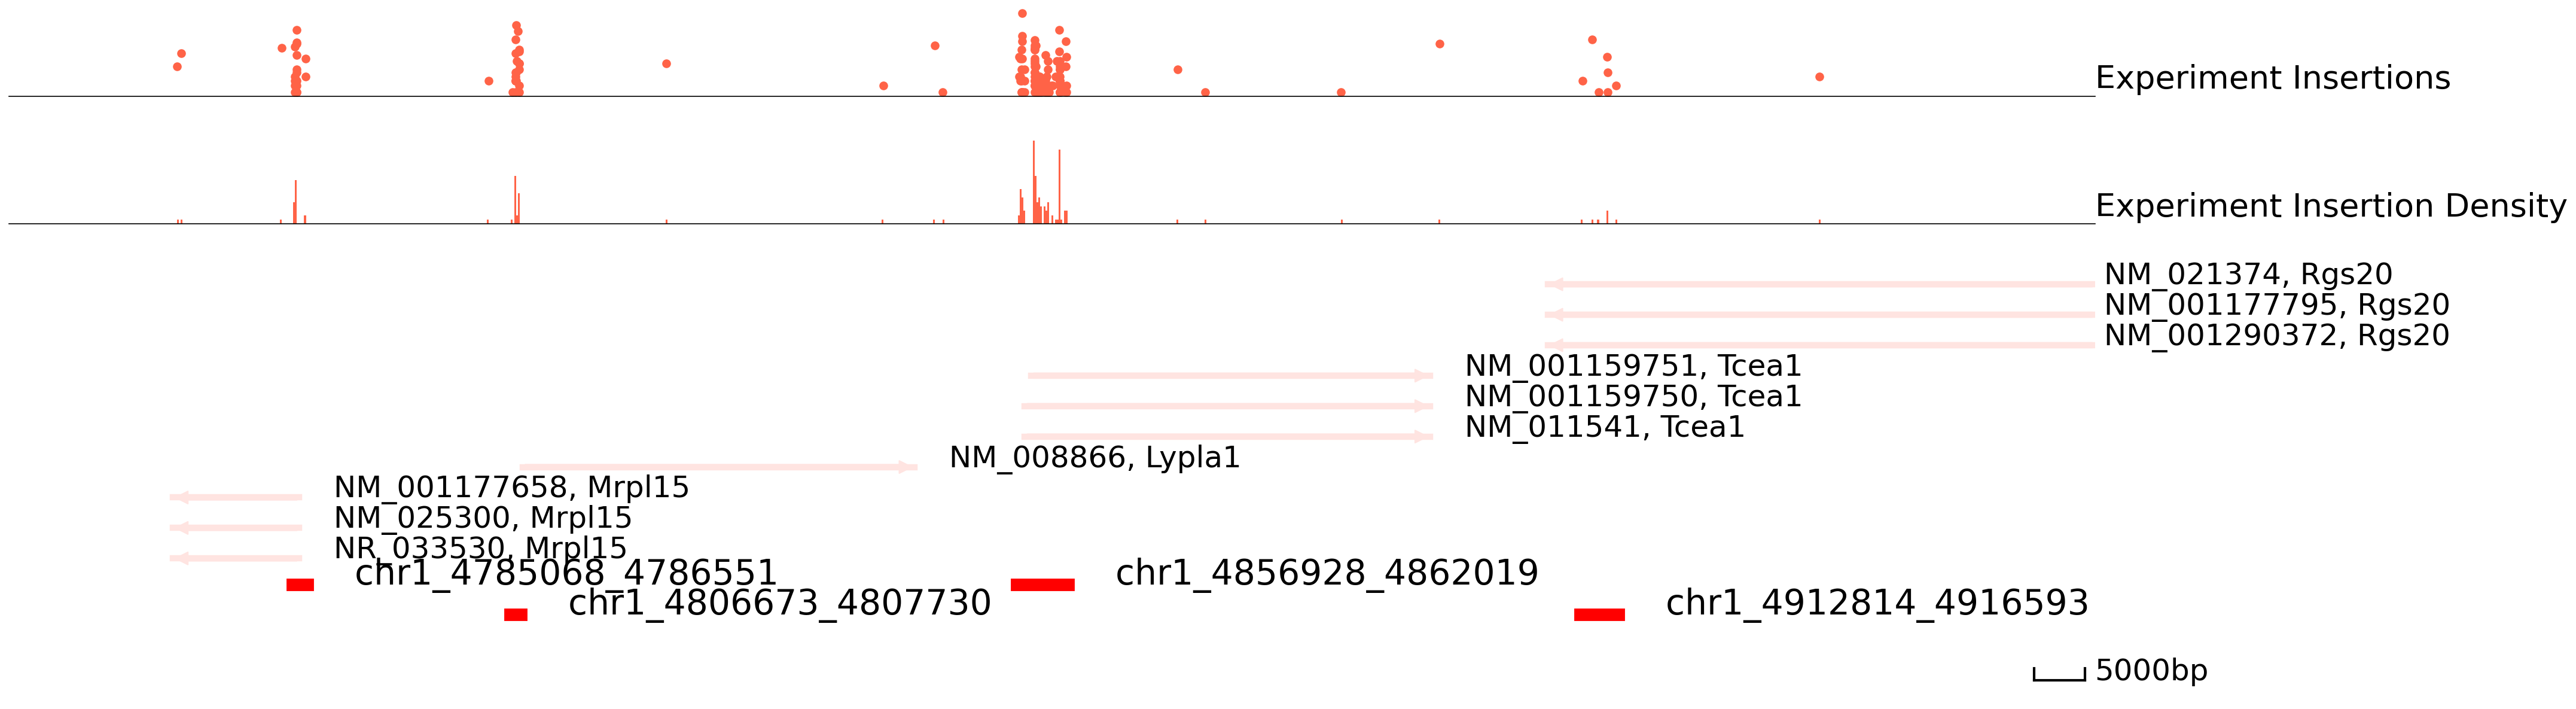

In [7]:
cc.pl.draw_area("chr1", 4856929, 4863861, 100000, peak_data, Brd4, "mm10", font_size = 2, 
                plotsize = [1,1,5], 
                figsize = (30,10), peak_line = 2, save = False, example_length = 5000)

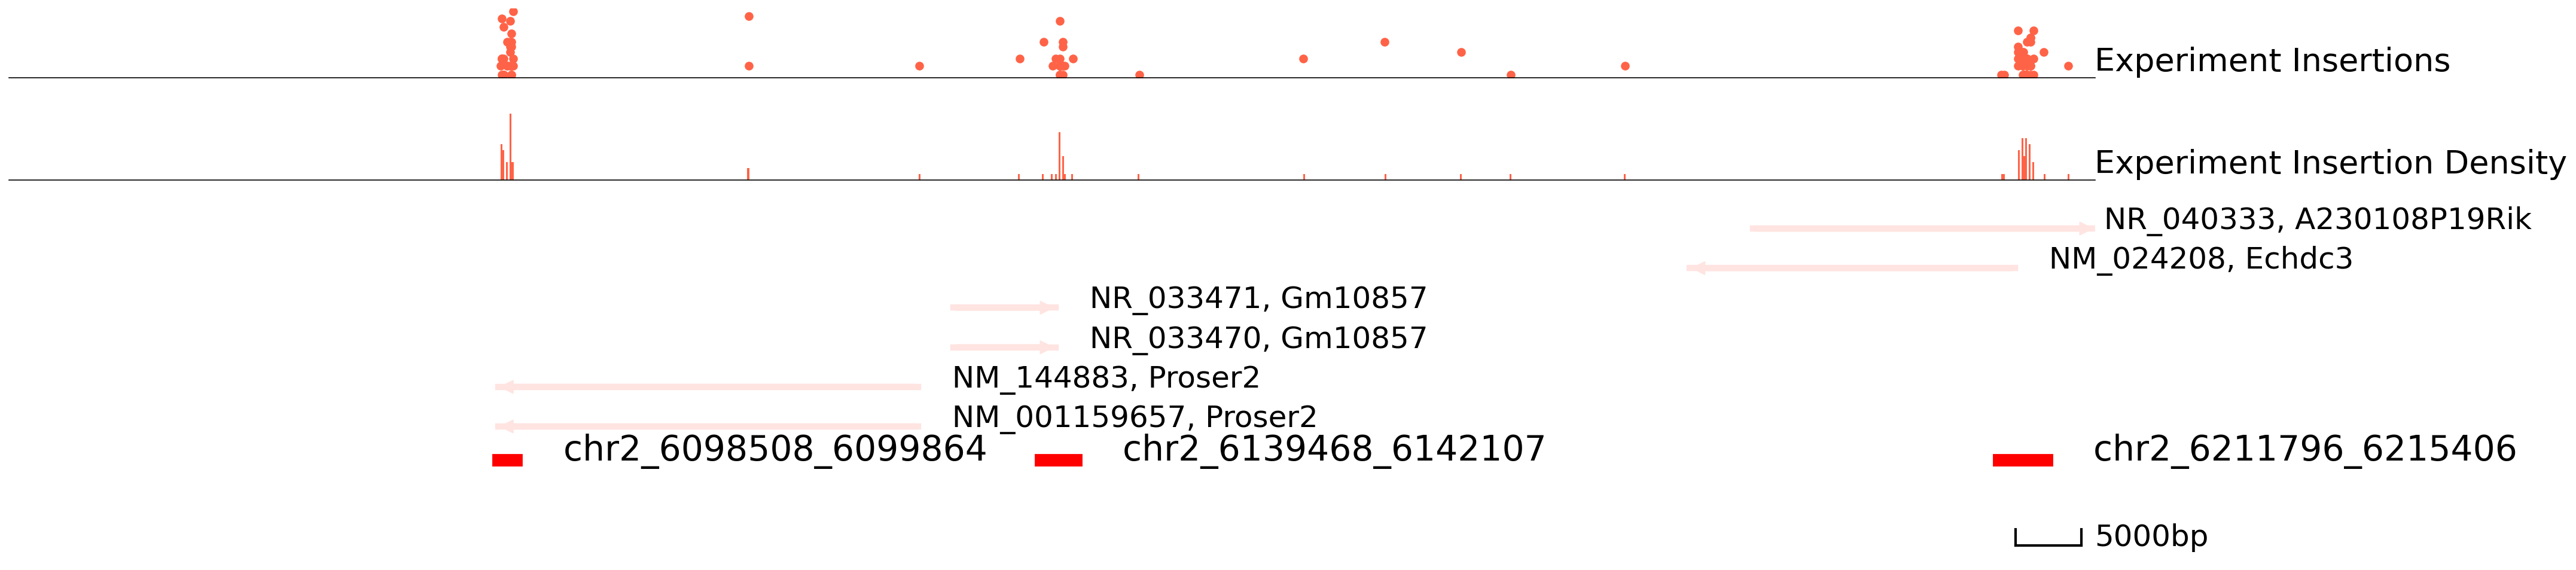

In [8]:
cc.pl.draw_area("chr2", 6136575, 6144043, 75000, peak_data, Brd4, "mm10", font_size = 2, plotsize = [1,1,5],
                figsize = (30,8), peak_line = 1, save = False, example_length = 5000)

We can also visualize our data directly in the [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/). This can be useful for overlaying your data with other published datasets. Notice that this link only valid for 24hrs, so please rerun it if you want to use it.

In [9]:
qbed = {"Brd4": Brd4}
bed = {"peak": peak_data}
cc.pl.WashU_browser_url(qbed = qbed, bed = bed, genome = 'mm10')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=mm10&hub=https://companion.epigenomegateway.org//task/544b112245ab68df385f75da9d4bfd8b/output//datahub.json


Pycallingcards can be used to visual peak locations acorss the genome to see if the distribution of peaks is unbiased and all chromosomes are represented.

In [10]:
cc.pl.whole_peaks(peak_data, reference = "mm10", linewidth = 1)

For differential peak calling, we recommend first combining the data and calling peaks together (and then splitting the data and looking for enrichments under the jointly called peaks). However, it is often of interest to call peaks in each sample to analyze them separately or to then merge these peak calls using [pybedtools](https://daler.github.io/pybedtools/). Below is the code to do this:

```python
import pybedtools
peak_data1 = cc.pp.call_peaks(Female_Brd4, method = "CCcaller", 
                              reference = "mm10", pvalue_cutoffbg = 0.1, 
                              maxbetween = 2000, pvalue_cutoffTTAA = 0.001, 
                              lam_win_size = 1000000,  pseudocounts = 0.1, record = True)
peak_data2 = cc.pp.call_peaks(Male_Brd4, method = "CCcaller", 
                              reference = "mm10",  pvalue_cutoffbg = 0.1, 
                              maxbetween = 2000, pvalue_cutoffTTAA = 0.001, 
                              lam_win_size = 1000000, pseudocounts = 0.1, record = True)
peak = cc.rd.combine_qbed([peak_data1, peak_data2])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})
```

In the next step, we annote each peak to annotate using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [11]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data, peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


Chr      Start        End  Experiment Insertions  \
0      chr1    4196775    4198714                     16   
1      chr1    4785068    4786551                     17   
2      chr1    4806673    4807730                     21   
3      chr1    4856928    4862019                    104   
4      chr1    4912814    4916593                      7   
...     ...        ...        ...                    ...   
24546  chrX  169936677  169937745                      7   
24547  chrY     897430     899700                     11   
24548  chrY    1009018    1011799                     27   
24549  chrY    1243715    1246316                     24   
24550  chrY    1282482    1287504                     19   

       Reference Insertions  Expected Insertions        pvalue    pvalue_adj  \
0                        12             0.142389  0.000000e+00  0.000000e+00   
1                        15             0.572576  0.000000e+00  0.000000e+00   
2                        12             0.477937  0.000000e+00  0.000000e+00   
3                        44             1.490080  0.000000e+00  0.000000e+00   
4                        22             0.791756  1.900897e-06  1.024407e-04   
...                     ...                  ...           ...           ...   
24546                     8             1.189526  3.479200e-05  1.673495e-03   
24547                    24             0.528165  6.046275e-13  5.162843e-11   
24548                    25             0.489073  0.000000e+00  0.000000e+00   
24549                    29             0.504932  0.000000e+00  0.000000e+00   
24550                    60             0.945958  0.000000e+00  0.000000e+00   

      Nearest Refseq1 Gene Name1 Direction1  Distance1 Nearest Refseq2  \
0        NM_001195662        Rp1          -      92132       NM_011283   
1           NR_033530     Mrpl15          -          0       NM_008866   
2           NM_008866     Lypla1          +        163       NR_033530   
3           NM_011541      Tcea1          +          0       NM_008866   
4        NM_001290372      Rgs20          -          0       NM_011541   
...               ...        ...        ...        ...             ...   
24546       NM_010797       Mid1          +          0       NR_029457   
24547       NM_011419      Kdm5d          +          0       NM_011667   
24548       NM_012011    Eif2s3y          +          0       NR_027507   
24549       NM_009484        Uty          -          0       NM_012008   
24550       NM_012008      Ddx3y          -          0       NM_148943   

          Gene Name2 Direction2  Distance2  
0                Rp1          -     144793  
1             Lypla1          +      21342  
2             Mrpl15          -     -20948  
3             Lypla1          +     -10194  
4              Tcea1          +     -14906  
...              ...        ...        ...  
24546  G530011O06Rik          -      37298  
24547          Uba1y          +     -53207  
24548        Tspy-ps          -      43965  
24549          Ddx3y          -      14399  
24550          Usp9y          -      11457  

[24551 rows x 16 columns]

Use qbed data, peak data, and barcode data to make a group by peak [Anndata](https://anndata.readthedocs.io/en/latest/) object.


In [12]:
adata_cc = cc.pp.make_Anndata(Brd4, peak_annotation, ["Female_Brd4", "Male_Brd4"], key = 'group')
adata_cc

100%|██████████| 21/21 [00:07<00:00,  2.64it/s]


AnnData object with n_obs × n_vars = 2 × 24551
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Direction1', 'Distance1', 'Nearest Refseq2', 'Gene Name2', 'Direction2', 'Distance2'

In [13]:
adata_cc.obs

Empty DataFrame
Columns: []
Index: [Female_Brd4, Male_Brd4]

In [14]:
adata_cc

AnnData object with n_obs × n_vars = 2 × 24551
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Direction1', 'Distance1', 'Nearest Refseq2', 'Gene Name2', 'Direction2', 'Distance2'

In [15]:
adata_cc = cc.tl.liftover(adata_cc)
adata_cc

100%|██████████| 24551/24551 [04:44<00:00, 86.27it/s] 


AnnData object with n_obs × n_vars = 2 × 24551
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Direction1', 'Distance1', 'Nearest Refseq2', 'Gene Name2', 'Direction2', 'Distance2', 'Chr_liftover', 'Start_liftover', 'End_liftover'

Differential peak analysis will find out the significant binding for each group. In this example, we use the *Fisher's exact test* to find out.

In [16]:
cc.tl.rank_peak_groups(adata_cc, 'Index', method = 'fisher_exact', key_added = 'fisher_exact')

100%|██████████| 2/2 [01:43<00:00, 51.87s/it]


Plot the results for differential peak analysis.

```python
cc.tl.rank_peak_groups(adata_cc, 'Index', method = 'fisher_exact', key_added = 'fisher_exact', 
                       rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact',rankby = 'logfoldchanges')

```

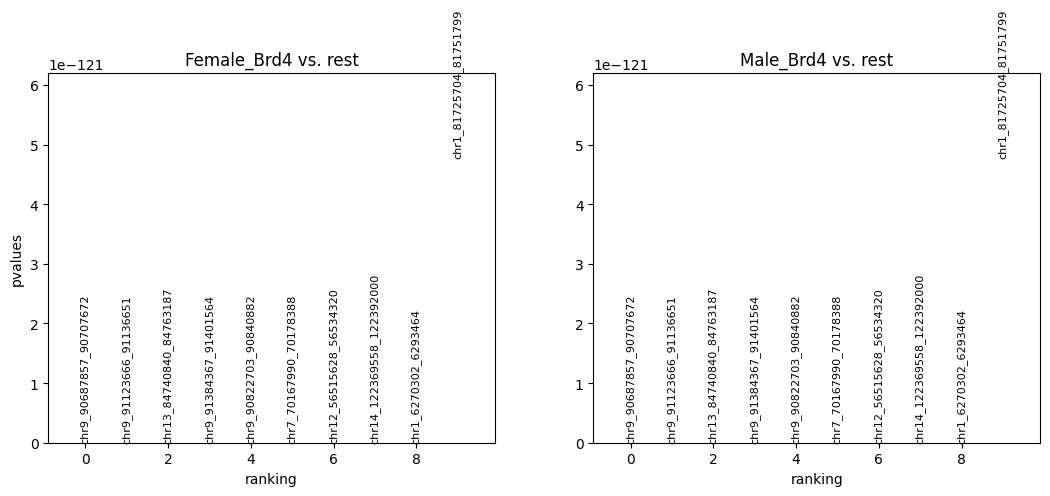

In [17]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact', rankby = 'pvalues')

We can use Pycallingcards to look at the insertion densities at peaks that are differentially bound.  In the plot below, we first plot female peaks as blue points and male as grey points, and then we plot male peaks as red and female peaks as grey.  From the plots below we can see there is much more Brd4 binding at this locus in females than in males.  

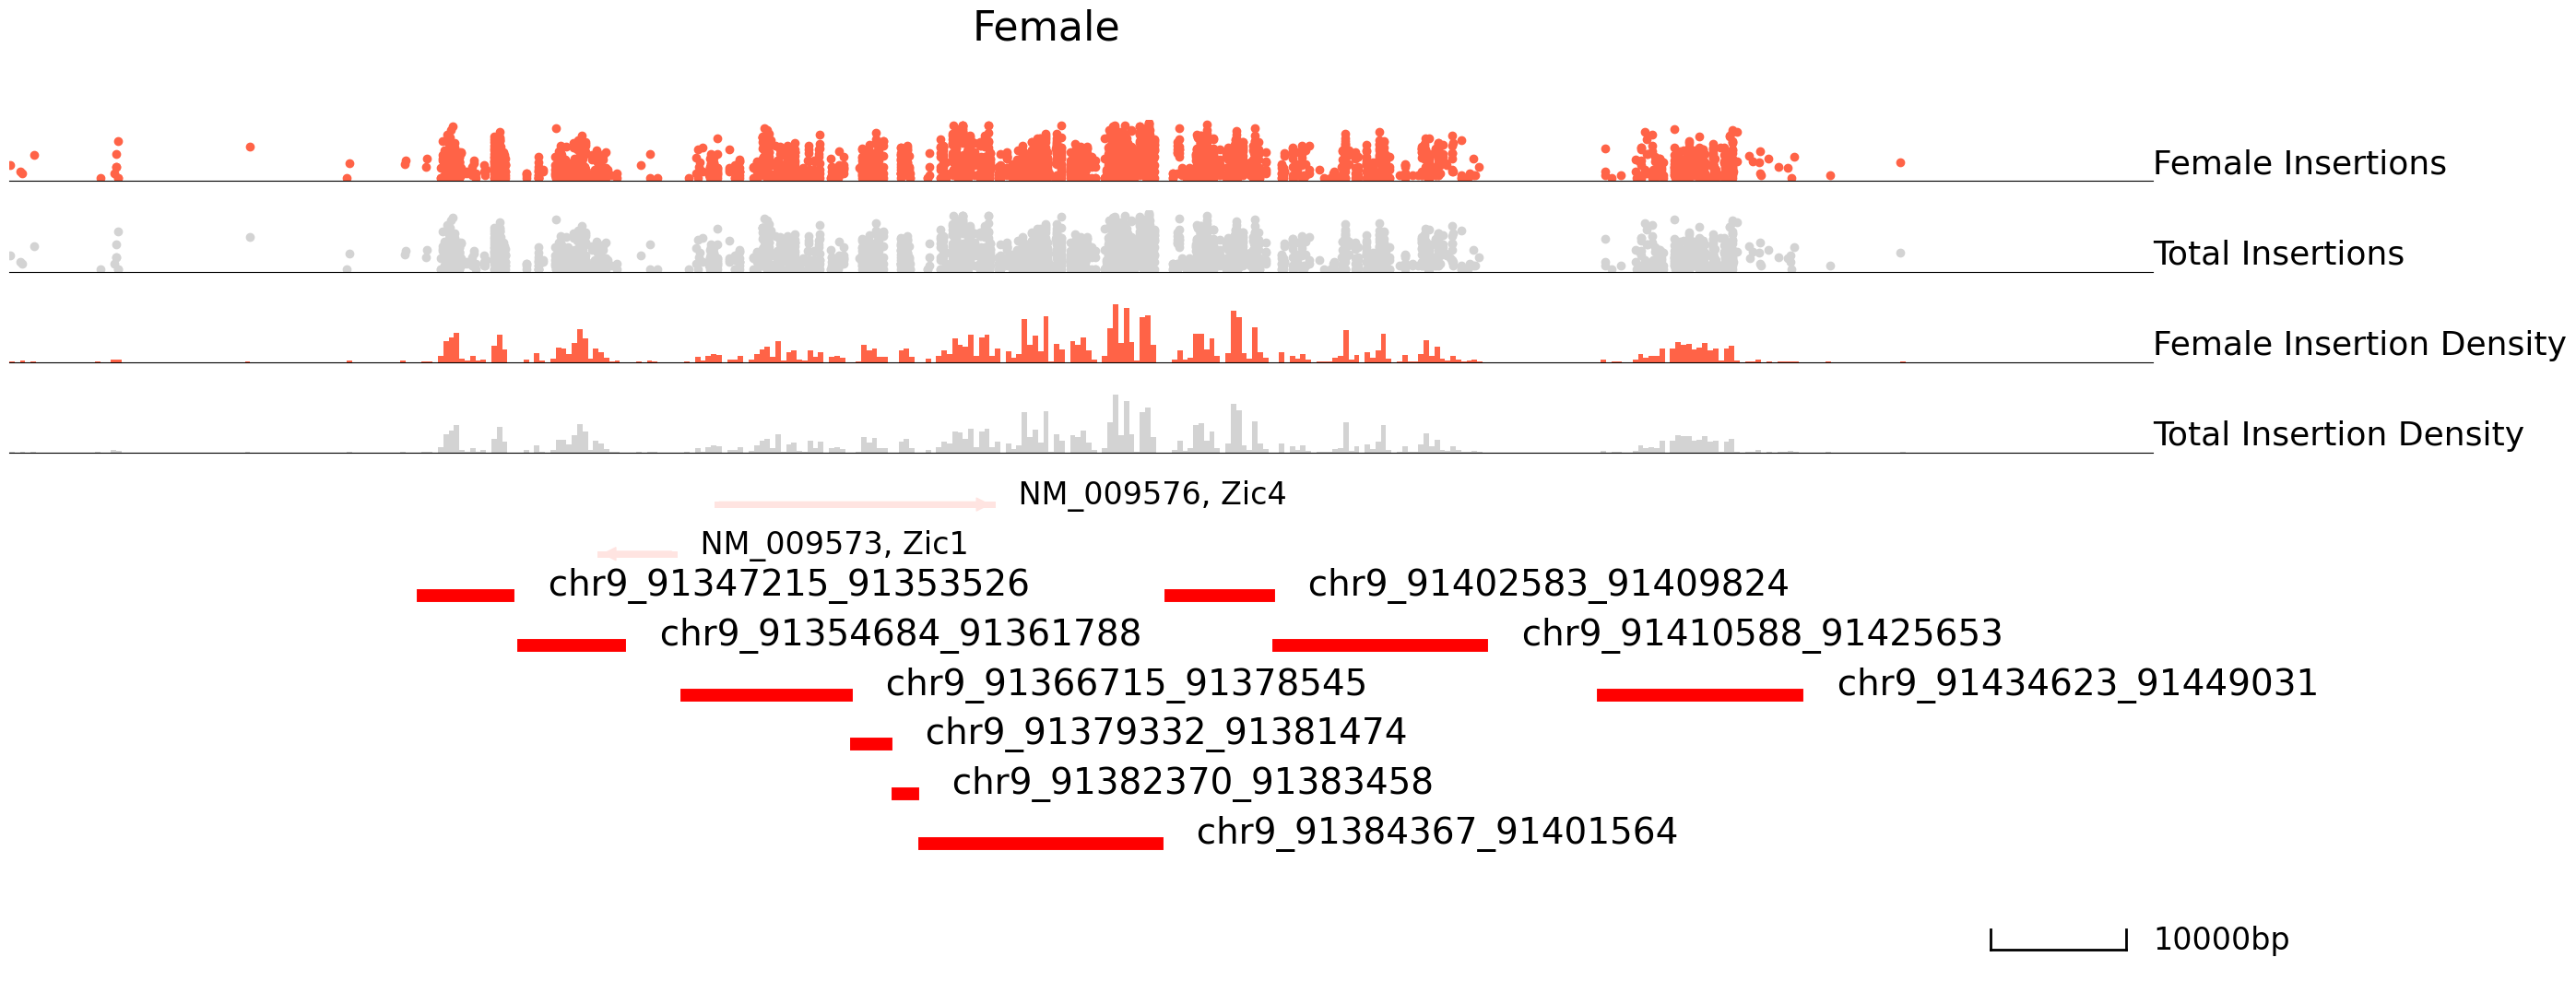

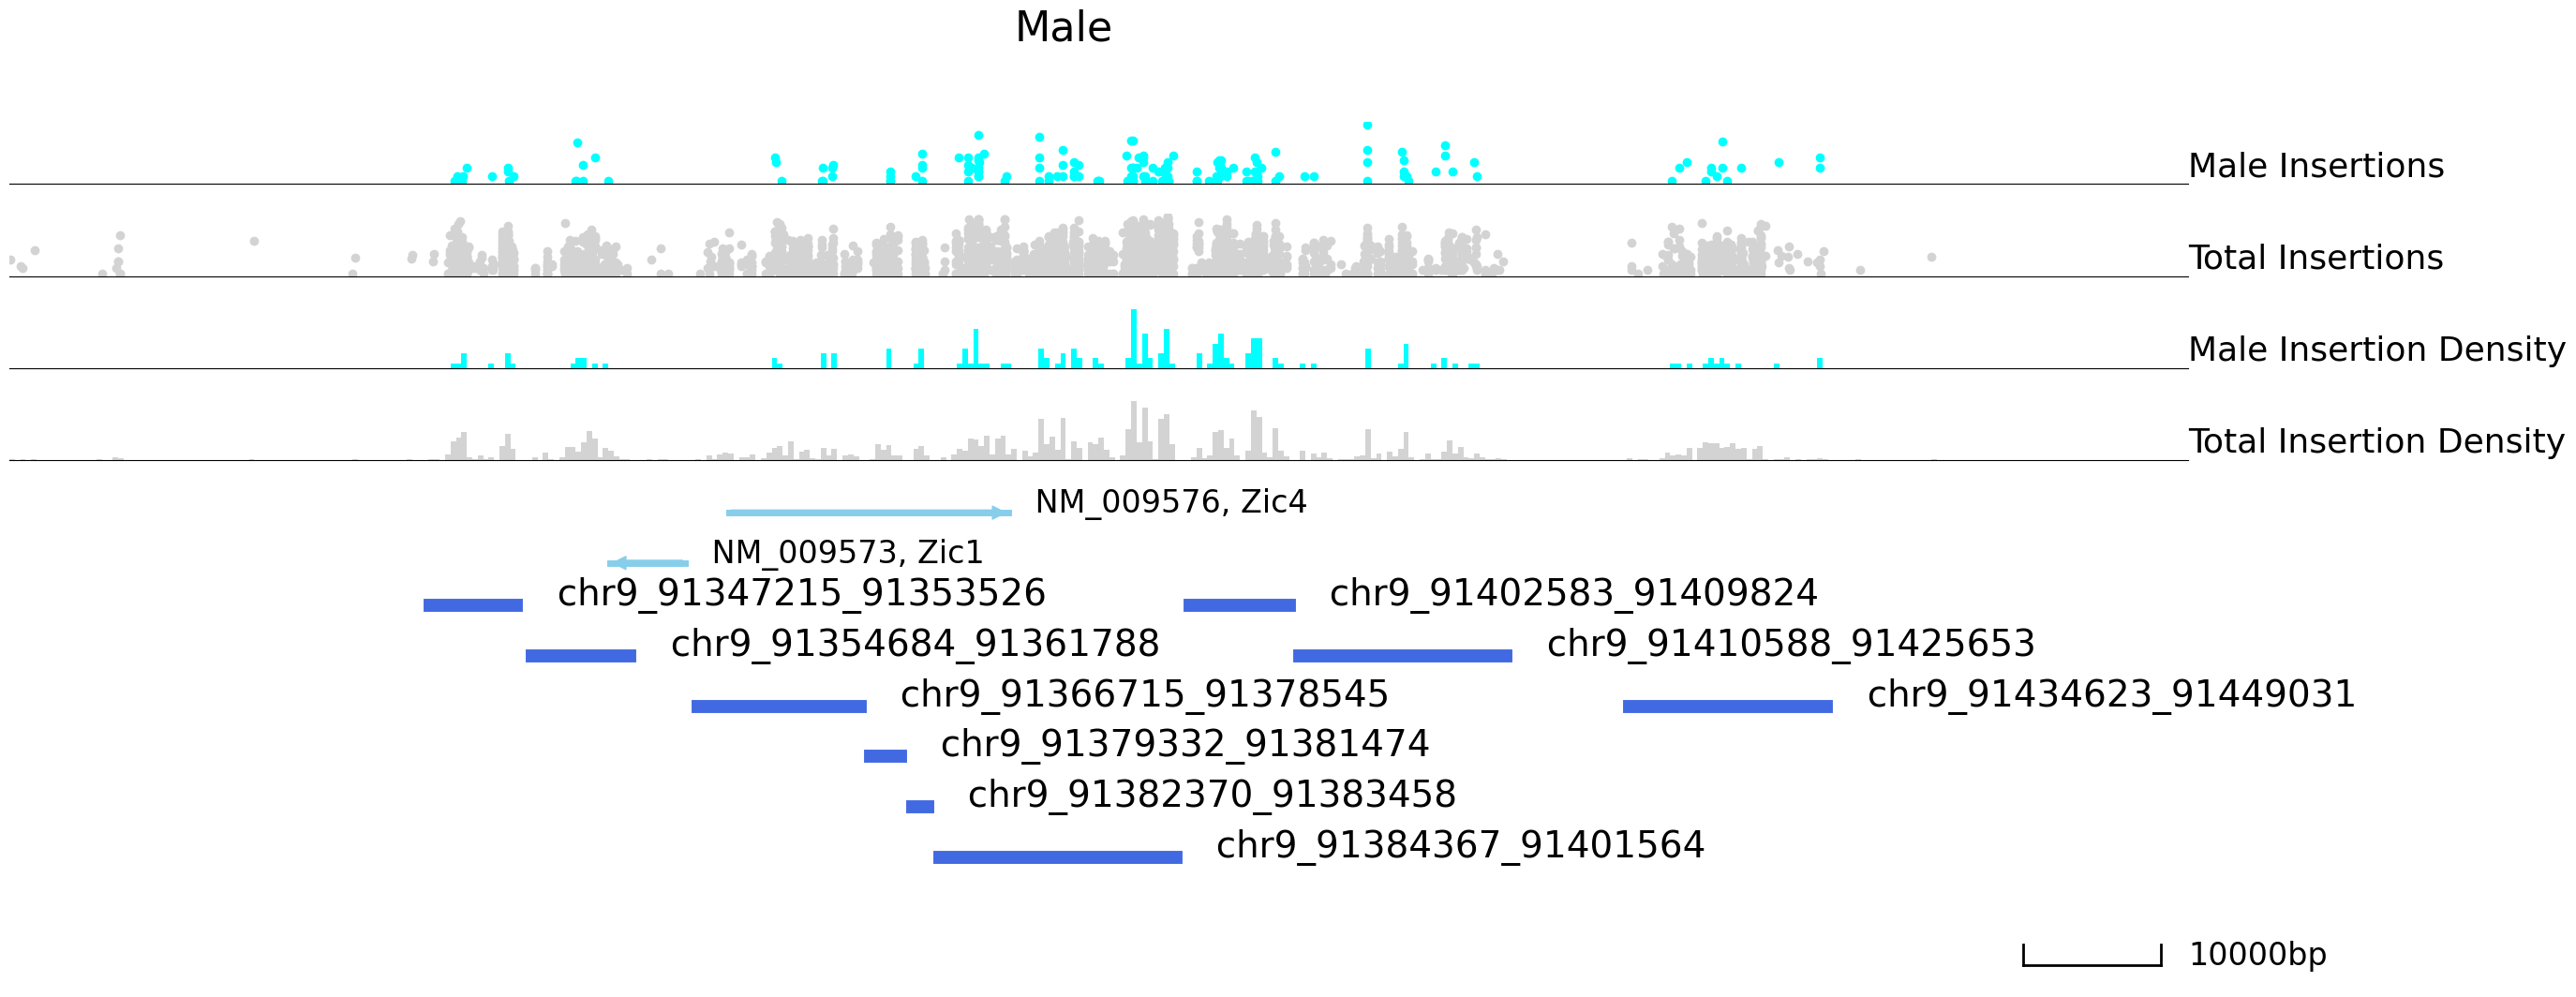

In [18]:
cc.pl.draw_area("chr9", 91366534, 91425373, 50000, peak_data, Brd4, "mm10", adata = adata_cc, font_size=2, 
                plotsize = [1,1,4], name = "Female_Brd4",key = "Index",insertionkey = "group", 
                name_insertion1 = 'Female Insertions', name_density1 = 'Female Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                bins = 400, figsize = (30,12), peak_line = 6, title = "Female")
cc.pl.draw_area("chr9", 91366534, 91425373, 50000, peak_data, Brd4, "mm10",  adata = adata_cc, font_size=2, 
                plotsize = [1,1,4], name = "Male_Brd4",key = "Index", insertionkey = "group",
                name_insertion1 = 'Male Insertions', name_density1 = 'Male Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                bins = 400, figsize = (30,12), peak_line = 6, color = "blue", title = "Male")

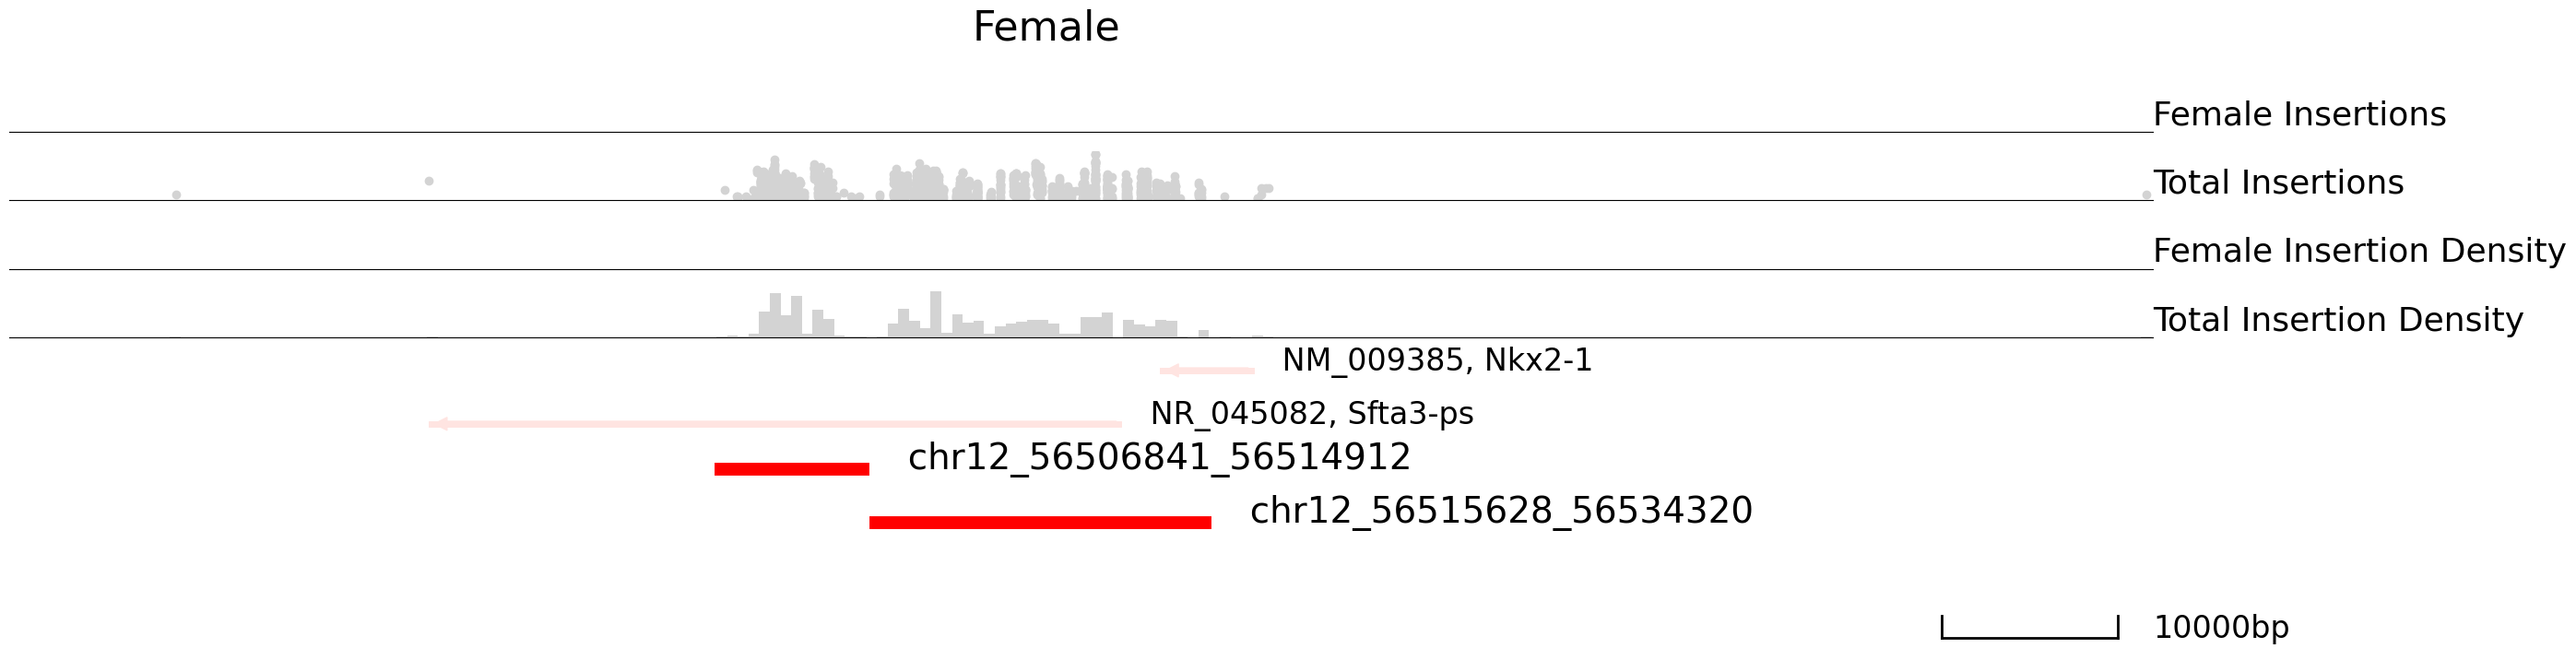

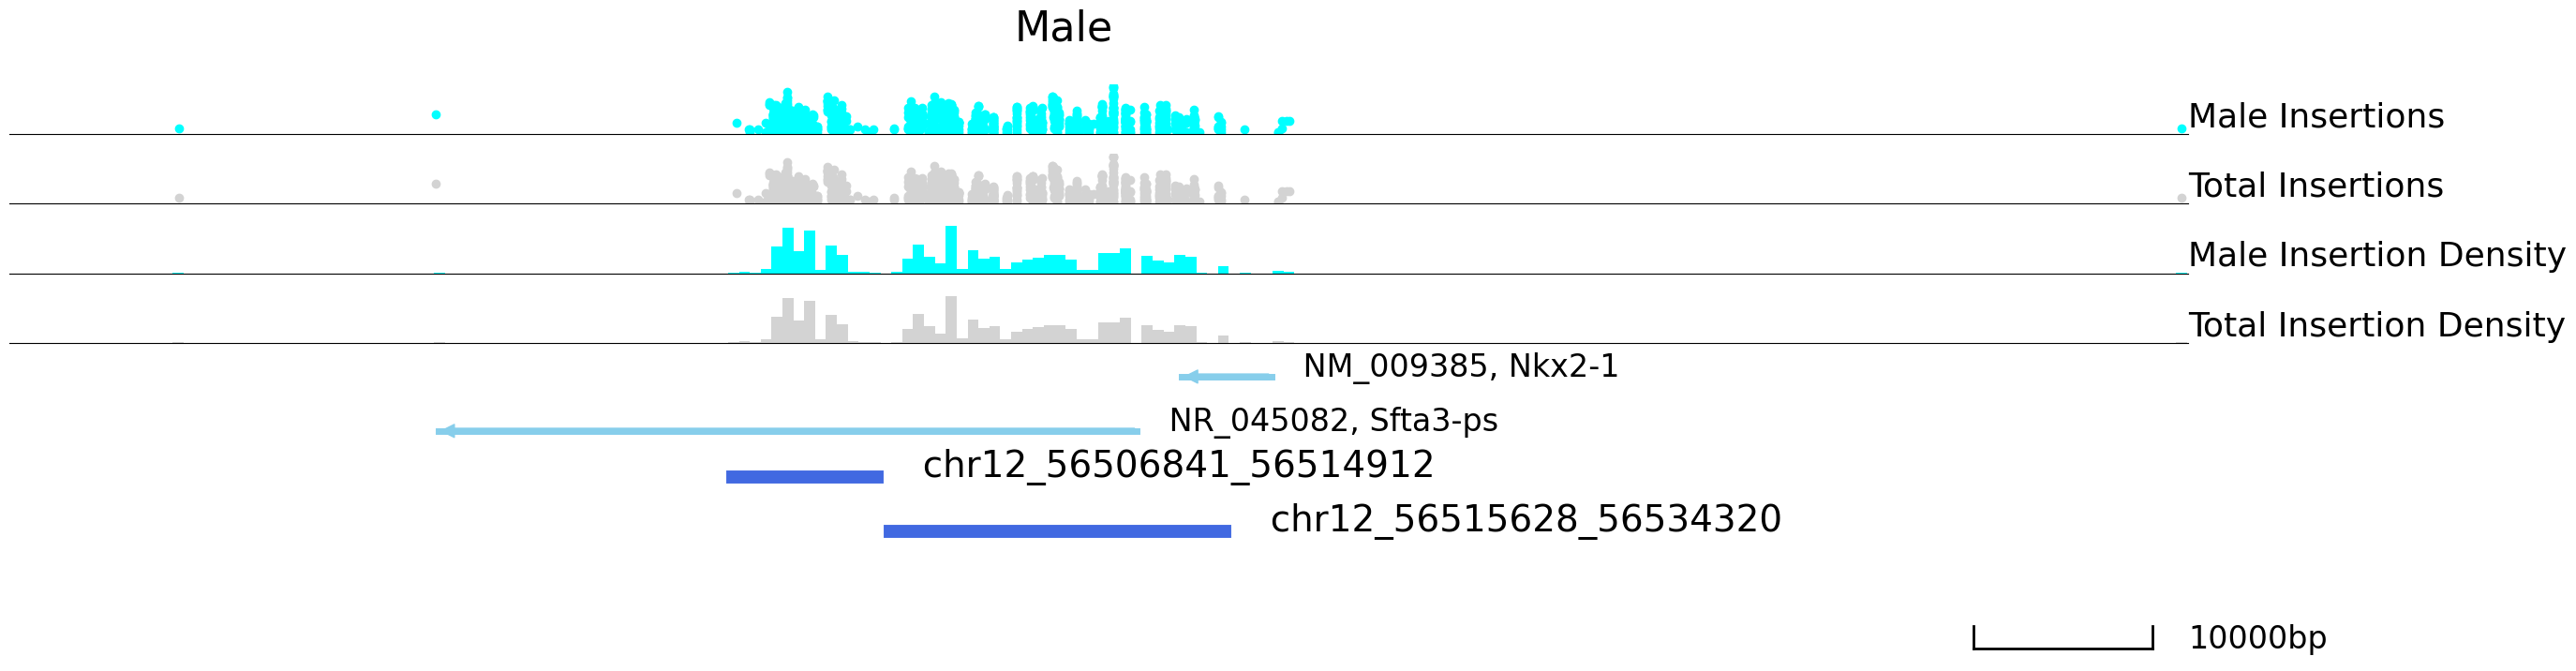

In [19]:
cc.pl.draw_area("chr12", 56516453, 56538107, 50000, peak_data, Brd4, "mm10", adata = adata_cc, font_size=2, 
                plotsize = [1,1,3], name = "Female_Brd4", key = "Index",insertionkey = "group", bins = 200,
                name_insertion1 = 'Female Insertions', name_density1 = 'Female Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                figsize = (30,8), peak_line = 2, title = "Female")
cc.pl.draw_area("chr12", 56516453, 56538107, 50000, peak_data, Brd4, "mm10", adata = adata_cc, font_size=2, 
                plotsize = [1,1,3], name = "Male_Brd4", key = "Index", insertionkey = "group", bins = 200,
                name_insertion1 = 'Male Insertions', name_density1 = 'Male Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                figsize = (30,8), peak_line = 2, color = "blue", title = "Male")

We can now plot a volcano plot to visualize the distribution of differentially bound peaks. labelright and labellest are the location points of the labels.

/home/juanru/Desktop/pycallingcards/pycallingcards/pycallingcards/plotting/_volcano.py:70: RuntimeWarning: divide by zero encountered in log10
  pva = -np.log10(np.array(adata_cc.uns[name][pvalue_name].tolist())[:, 1])


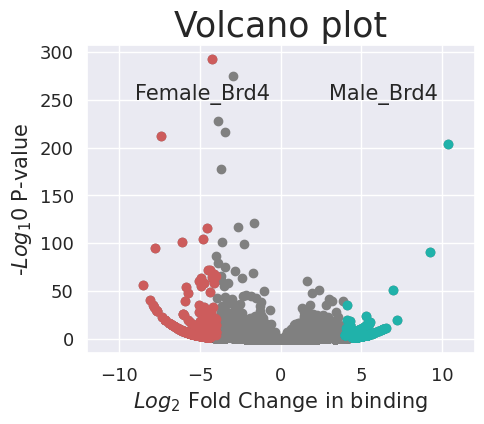

In [20]:
cc.pl.volcano_plot(adata_cc, pvalue_name = 'pvalues_adj', pvalue_cutoff = 0.01, lfc_cutoff = 4,
                   figsize = (5,4), labelright = (3,250), labelleft = (-9,250))

We can now use [HOMER](http://homer.ucsd.edu/homer/motif/) to call motifs for both female and male bound peaks separately to find out potential motif binding difference.

In [31]:
cc.tl.call_motif(peaks_frame=cc.tl.rank_peak_groups_df(adata_cc, key = 'fisher_exact', pval_cutoff = 0.01, logfc_min = 3, group = ['Female_Brd4'])["names"].str.split("_", expand=True),
                 reference ="mm10",save_homer = "Homer/GBM_female", 
                 homer_path = "/home/juanru/miniconda3/bin/", num_cores=12)
cc.tl.call_motif(peaks_frame=cc.tl.rank_peak_groups_df(adata_cc, key = 'fisher_exact', pval_cutoff = 0.01, logfc_min = 3, group = ['Male_Brd4'])["names"].str.split("_", expand=True),
                 reference ="mm10",save_homer = "Homer/GBM_male", 
                 homer_path = "/home/juanru/miniconda3/bin/", num_cores=12)

There is no save_name, it will save to temp_Homer_trial.bed and then delete.



	Position file = temp_Homer_trial.bed
	Genome = mm10
	Output Directory = Homer/GBM_female
	Fragment size set to 1000
	Using 12 CPUs
	Will not run homer for de novo motifs
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 1009
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 1009
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 1000 bp fragments found.
	Custom genome sequence directory: /home/juanru/miniconda3/share/homer/.//data/genomes/mm10//

	Extracting sequences from directory: /home/juanru/miniconda3/share/homer/.//data/genomes/mm10//
	Extracting 96 sequences from chr1
	Extracting 93 sequences from chr2
	Extracting 62 sequences from chr3
	Extracting 39 sequences from chr4


Finished!
There is no save_name, it will save to temp_Homer_trial.bed and then delete.


	Background files for 1000 bp fragments found.
	Custom genome sequence directory: /home/juanru/miniconda3/share/homer/.//data/genomes/mm10//

	Extracting sequences from directory: /home/juanru/miniconda3/share/homer/.//data/genomes/mm10//
	Extracting 36 sequences from chr1
	Extracting 40 sequences from chr2
	Extracting 33 sequences from chr3
	Extracting 20 sequences from chr4
	Extracting 28 sequences from chr5
	Extracting 35 sequences from chr6
	Extracting 18 sequences from chr7
	Extracting 25 sequences from chr8
	Extracting 21 sequences from chr9
	Extracting 52 sequences from chr10
	Extracting 39 sequences from chr11
	Extracting 26 sequences from chr12
	Extracting 23 sequences from chr13
	Extracting 36 sequences from chr14
	Extracting 43 sequences from chr15
	Extracting 18 sequences from chr16
	Extracting 17 sequences from chr17
	Extracting 28 sequences from chr18
	Extracting 22 sequences from chr19
	Extracting 21 sequences from chrX
	Extracting 4 sequences from chrY

	Not removing re

Finished!



	Preparing HTML output with sequence logos...
		1 of 440 (1e-42) Fosl2(bZIP)/3T3L1-Fosl2-ChIP-Seq(GSE56872)/Homer
		2 of 440 (1e-41) Jun-AP1(bZIP)/K562-cJun-ChIP-Seq(GSE31477)/Homer
		3 of 440 (1e-39) Fos(bZIP)/TSC-Fos-ChIP-Seq(GSE110950)/Homer
		4 of 440 (1e-38) JunB(bZIP)/DendriticCells-Junb-ChIP-Seq(GSE36099)/Homer
		5 of 440 (1e-37) Fra1(bZIP)/BT549-Fra1-ChIP-Seq(GSE46166)/Homer
		6 of 440 (1e-35) Fra2(bZIP)/Striatum-Fra2-ChIP-Seq(GSE43429)/Homer
		7 of 440 (1e-35) BATF(bZIP)/Th17-BATF-ChIP-Seq(GSE39756)/Homer
		8 of 440 (1e-34) Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer
		9 of 440 (1e-34) AP-1(bZIP)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer
		10 of 440 (1e-22) Bach2(bZIP)/OCILy7-Bach2-ChIP-Seq(GSE44420)/Homer
		11 of 440 (1e-10) Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)/Homer
		12 of 440 (1e-9) NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer
		13 of 440 (1e-7) Bach1(bZIP)/K562-Bach1-ChIP-Seq(GSE31477)/Homer
		14 of 440 (1e-7) NFE2L2(bZIP)/HepG2-NFE2L2-ChIP-Seq(Encode)/Homer
		1

Find motifs under male peaks but not in female peaks.

In [22]:
cc.tl.compare_motif("Homer/GBM_male", "Homer/GBM_female")

Motif Name        Consensus  \
10  Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)...     HTGCTGAGTCAT   
11     NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer     GATGACTCAGCA   
12   NFE2L2(bZIP)/HepG2-NFE2L2-ChIP-Seq(Encode)/Homer  AWWWTGCTGAGTCAT   
13    Bach1(bZIP)/K562-Bach1-ChIP-Seq(GSE31477)/Homer  AWWNTGCTGAGTCAT   
14     MafK(bZIP)/C2C12-MafK-ChIP-Seq(GSE36030)/Homer     GCTGASTCAGCA   
15  Ets1-distal(ETS)/CD4+-PolII-ChIP-Seq(Barski_et...       MACAGGAAGT   
17        Sox3(HMG)/NPC-Sox3-ChIP-Seq(GSE33059)/Homer         CCWTTGTY   
18  Nkx2.2(Homeobox)/NPC-Nkx2.2-ChIP-Seq(GSE61673)...       BTBRAGTGSN   
19  Bapx1(Homeobox)/VertebralCol-Bapx1-ChIP-Seq(GS...       TTRAGTGSYK   
20  RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer       AAACCACARM   
23  ZNF669(Zf)/HEK293-ZNF669.GFP-ChIP-Seq(GSE58341...  GARTGGTCATCGCCC   
27  RUNX-AML(Runt)/CD4+-PolII-ChIP-Seq(Barski_et_a...       GCTGTGGTTW   
29  Sox10(HMG)/SciaticNerve-Sox3-ChIP-Seq(GSE35132...       CCWTTGTYYB   
30                             Sp1(Zf)/Promoter/Homer     GGCCCCGCCCCC   
32        E2F3(E2F)/MEF-E2F3-ChIP-Seq(GSE71376)/Homer     BTKGGCGGGAAA   
37       Sox7(HMG)/ESC-Sox7-ChIP-Seq(GSE133899)/Homer     VVRRAACAATGG   
40  Brn1(POU,Homeobox)/NPC-Brn1-ChIP-Seq(GSE35496)...     TATGCWAATBAV   
42       Sox4(HMG)/proB-Sox4-ChIP-Seq(GSE50066)/Homer       YCTTTGTTCC   
43  ZNF317(Zf)/HEK293-ZNF317.GFP-ChIP-Seq(GSE58341...  GTCWGCTGTYYCTCT   
45  OCT4-SOX2-TCF-NANOG(POU,Homeobox,HMG)/mES-Oct4...  ATTTGCATAACAATG   
46  Isl1(Homeobox)/Neuron-Isl1-ChIP-Seq(GSE31456)/...         CTAATKGV   
48        Sox2(HMG)/mES-Sox2-ChIP-Seq(GSE11431)/Homer       BCCATTGTTC   
49        Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer       TGCGTGGGYG   
50  Tbx20(T-box)/Heart-Tbx20-ChIP-Seq(GSE29636)/Homer     GGTGYTGACAGS   
51  Nkx3.1(Homeobox)/LNCaP-Nkx3.1-ChIP-Seq(GSE2826...       AAGCACTTAA   
52       E2F6(E2F)/Hela-E2F6-ChIP-Seq(GSE31477)/Homer       GGCGGGAARN   
53                       TATA-Box(TBP)/Promoter/Homer     CCTTTTAWAGSC   
55         Klf9(Zf)/GBM-Klf9-ChIP-Seq(GSE62211)/Homer     GCCACRCCCACY   

         P-value  Log P-value  q-value (Benjamini)  \
10  1.000000e-13      -30.290               0.0000   
11  1.000000e-11      -26.520               0.0000   
12  1.000000e-11      -25.480               0.0000   
13  1.000000e-09      -21.840               0.0000   
14  1.000000e-09      -20.870               0.0000   
15  1.000000e-05      -13.680               0.0000   
17  1.000000e-04       -9.625               0.0016   
18  1.000000e-04       -9.612               0.0016   
19  1.000000e-04       -9.553               0.0016   
20  1.000000e-03       -8.988               0.0026   
23  1.000000e-03       -8.215               0.0050   
27  1.000000e-03       -7.530               0.0086   
29  1.000000e-03       -7.342               0.0095   
30  1.000000e-03       -7.220               0.0104   
32  1.000000e-03       -7.074               0.0113   
37  1.000000e-02       -6.569               0.0162   
40  1.000000e-02       -6.345               0.0188   
42  1.000000e-02       -6.213               0.0205   
43  1.000000e-02       -6.112               0.0222   
45  1.000000e-02       -5.636               0.0341   
46  1.000000e-02       -5.578               0.0354   
48  1.000000e-02       -5.408               0.0402   
49  1.000000e-02       -5.339               0.0422   
50  1.000000e-02       -5.310               0.0426   
51  1.000000e-02       -5.277               0.0432   
52  1.000000e-02       -5.256               0.0433   
53  1.000000e-02       -5.201               0.0449   
55  1.000000e-02       -5.137               0.0462   

    # of Target Sequences with Motif(of 585) % of Target Sequences with Motif  \
10                                      39.0                            6.67%   
11                                      41.0                            7.01%   
12                                      48.0                            8.21%   
13   

Find motifs in female but not in male.

In [23]:
cc.tl.compare_motif("Homer/GBM_female", "Homer/GBM_male")

Motif Name        Consensus  \
0         Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer       MTGATGCAAT   
1         Chop(bZIP)/MEF-Chop-ChIP-Seq(GSE35681)/Homer       ATTGCATCAT   
2         IRF8(IRF)/BMDM-IRF8-ChIP-Seq(GSE77884)/Homer     GRAASTGAAAST   
5          EBF1(EBF)/Near-E2A-ChIP-Seq(GSE21512)/Homer     GTCCCCWGGGGA   
8           Zic3(Zf)/mES-Zic3-ChIP-Seq(GSE37889)/Homer  GGCCYCCTGCTGDGH   
..                                                 ...              ...   
122    SPDEF(ETS)/VCaP-SPDEF-ChIP-Seq(SRA014231)/Homer       ASWTCCTGBT   
123  Srebp2(bHLH)/HepG2-Srebp2-ChIP-Seq(GSE31477)/H...     CGGTCACSCCAC   
124  ZNF519(Zf)/HEK293-ZNF519.GFP-ChIP-Seq(GSE58341...       GAGSCCGAGC   
125  AP-2alpha(AP2)/Hela-AP2alpha-ChIP-Seq(GSE31477...     ATGCCCTGAGGC   
126     Atf7(bZIP)/3T3L1-Atf7-ChIP-Seq(GSE56872)/Homer     NGRTGACGTCAY   

          P-value  Log P-value  q-value (Benjamini)  \
0    1.000000e-14      -33.810               0.0000   
1    1.000000e-14      -32.890               0.0000   
2    1.000000e-12      -28.550               0.0000   
5    1.000000e-11      -27.250               0.0000   
8    1.000000e-11      -25.440               0.0000   
..            ...          ...                  ...   
122  1.000000e-02       -4.786               0.0299   
123  1.000000e-02       -4.760               0.0304   
124  1.000000e-02       -4.720               0.0314   
125  1.000000e-02       -4.695               0.0319   
126  1.000000e-02       -4.676               0.0323   

     # of Target Sequences with Motif(of 1009)  \
0                                        228.0   
1                                        197.0   
2                                        255.0   
5                                        310.0   
8                                        189.0   
..                                         ...   
122                                      420.0   
123                                       45.0   
124                                       37.0   
125                                      167.0   
126                                      192.0   

    % of Target Sequences with Motif  \
0                             22.60%   
1                             19.52%   
2                             25.27%   
5                             30.72%   
8                             18.73%   
..                               ...   
122                           41.63%   
123                            4.46%   
124                            3.67%   
125                           16.55%   
126                           19.03%   

     # of Background Sequences with Motif(of 2327)  \
0                                            313.9   
1                                            259.5   
2                                            381.5   
5                                            495.0   
8                                            266.5   
..                                             ...   
122                                          882.4   
123                                           71.8   
124                                           56.1   
125                                          323.9   
126                                          377.5   

    % of Background Sequences with Motif  
0                                 13.49%  
1                                 11.15%  
2                                 16.40%  
5                                 21.27%  
8                                 11.45%  
..                                   ...  
122                               37.92%  
123                                3.08%  
124                                2.41%  
125                               13.92%  
126                               16.22%  

[98 rows x 9 columns]

Next, we want to identify differentially bound peaks whose nearby genes are differentially expressed between males and females. To do so, we must first read in the bulk RNA-seq data. Note that this RNA-seq data is normalized by [RPKM](https://wiki.arrayserver.com/wiki/index.php?title=RPKM).

In [24]:
rna =  cc.datasets.mouse_brd4_data(data = "RNA")
rna

sample.f6_dmso_3  sample.f6_dmso_2  sample.f6_dmso_1  \
mt-Tf                  0.000000          0.639272          0.000000   
mt-Rnr1              127.907281        184.396768        172.544723   
mt-Tv                  0.000000          0.000000          1.761150   
mt-Rnr2              247.267306        527.855824        324.345998   
mt-Tl1                44.418710        117.660098         70.481211   
...                         ...               ...               ...   
Gm16897                0.281553          0.349020          0.463442   
A330023F24Rik          0.118678          0.055749          0.058441   
Cd46                   0.127930          0.095151          0.075997   
Cr1l                   9.993119         14.027801         13.717564   
Cr2                    0.018832          0.056028          0.019578   

               sample.m6_dmso_3  sample.m6_dmso_2  sample.m6_dmso_1  
mt-Tf                  1.156308          0.000000          0.687531  
mt-Rnr1              130.417054        192.566581        114.212201  
mt-Tv                  0.000000          0.510777          0.000000  
mt-Rnr2              675.031187        684.376279        418.345603  
mt-Tl1               167.217607        115.129081        127.789076  
...                         ...               ...               ...  
Gm16897                0.078913          0.070742          0.112610  
A330023F24Rik          0.029411          0.018833          0.049965  
Cd46                   0.061467          0.055103          0.087715  
Cr1l                  13.586101         13.240219         11.089902  
Cr2                    0.012668          0.017034          0.015064  

[21430 rows x 6 columns]

We now plot the heatmap for calling cards data and gene expression data. 

The top lines are the relative Brd4 binding for each of the two groups. The bottom lines are the gene expressions of the top two nearest genes in the 3 RNA-seq replicates for males and females; each gene shown separately. 

We can see a relationship between Brd4 binding and the expression of nearby genes. Genes that are strongly bound in females tend to be expressed in females and expressed at lower levels in males and vice versa. The effect is much more muted for the 2nd nearest gene to the peak. 

Please make sure that the samples in adata_cc and rna are in the same order.


/home/juanru/Desktop/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:193: RuntimeWarning: invalid value encountered in true_divide
  data[groupnumber:secondnum, :]
/home/juanru/Desktop/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:195: RuntimeWarning: invalid value encountered in true_divide
  data[secondnum:, :]


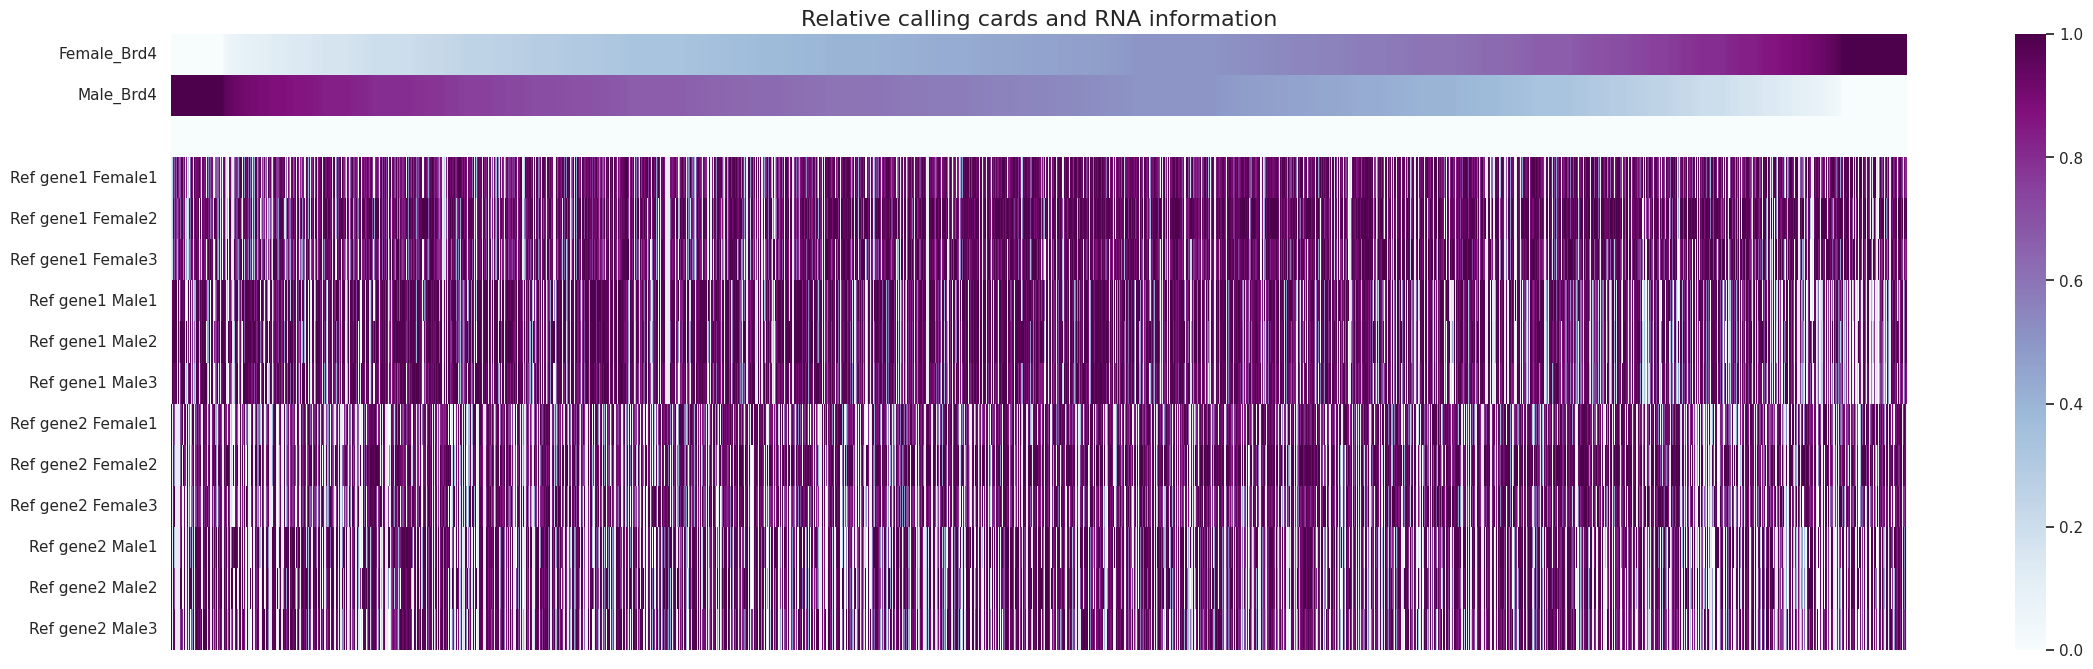

In [25]:
cc.pl.heatmap(adata_cc,rna, rnalabels = ["Female1", "Female2", "Female3","Male1", "Male2", "Male3"])

Find out the co-differential peak-gene pairs. Look into all the differential peaks and then see if the annotated genes are also significantly expressed. We can set the pvalue and score/log foldchange cutoff easily.


In [26]:
result = cc.tl.pair_peak_gene_bulk(adata_cc, "https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/deseq_MF.csv", 
                                   name_cc = 'logfoldchanges', pvalue_cutoff_cc = 0.001, pvalue_cutoff_rna = 0.001, 
                                   lfc_cutoff_rna = 5, lfc_cutoff_cc = 5)
result

Peak  logfoldchanges_peak    Pvalue_peak  \
0    chr1_174659622_174662521             5.652435   1.530047e-08   
1    chr1_174917639_174921559             6.208699   2.711848e-12   
2      chr2_93645657_93648162             5.189615   2.360560e-06   
3      chr3_33140350_33142508             5.534632   6.455627e-08   
4    chr3_126498429_126499612             5.337659   5.594815e-07   
5    chr3_126657669_126660188            -5.397757   5.546104e-07   
6    chr3_132085669_132092999             6.121213  1.509244e-105   
7    chr3_132093815_132106295             5.072335   9.590057e-65   
8    chr3_141699368_141702608             6.065565   2.403341e-29   
9      chr4_68535893_68538867             5.172571   1.974087e-15   
10     chr4_68545353_68551019             6.825275   1.516093e-18   
11   chr4_118022206_118024522            -5.332271   1.094775e-06   
12     chr5_13001869_13003460             5.957213   2.037009e-10   
13     chr5_13276479_13283560             7.727895   3.536779e-34   
14     chr5_17080302_17082934             5.024623   9.959617e-06   
15     chr5_28465271_28467276            -5.397757   5.546104e-07   
16     chr5_38081825_38086331             6.088429   2.350343e-11   
17     chr7_56523378_56528436             6.721266   2.699280e-17   
18   chr7_111875691_111878313             5.109476   4.848742e-06   
19     chr8_82329336_82331284             5.189615   2.360560e-06   
20   chr8_102781569_102784308             5.761340   3.626346e-09   
21    chr11_96341058_96343216             5.337659   5.594815e-07   
22    chr11_96354206_96355627             5.109476   4.848742e-06   
23    chr11_96354206_96355627             5.109476   4.848742e-06   
24    chr12_56506841_56514912            -9.259195   2.083740e-95   
25  chr13_117409406_117414817            -5.127606   3.397970e-15   
26    chr14_66104432_66107303             6.455571   1.757505e-14   
27    chr14_88460573_88463273             5.594736   3.142836e-08   
28    chr14_88898125_88900211            -5.263671   2.162151e-06   
29    chr15_11692586_11694713             6.046002   4.827833e-11   
30    chr15_11743634_11745456             6.922288   8.515240e-20   
31    chr15_11782997_11784930             5.957213   2.037009e-10   
32    chr18_53465649_53470088             5.761340   3.626346e-09   
33    chr19_59159949_59161669            -6.094880   4.260481e-11   
34    chr19_59163812_59165938            -5.788022   4.812885e-09   
35     chrX_93281556_93288401             5.093695   9.655833e-32   
36       chrY_1009018_1011799            -5.686862   1.864054e-08   
37       chrY_1243715_1246316            -5.520433   1.425488e-07   
38       chrY_1243715_1246316            -5.520433   1.425488e-07   
39       chrY_1282482_1287504            -5.191646   4.272455e-06   

    Pvalue_adj_peak     Gene  Score_gene    Pvalue_gene  Pvalue_adj_gene  \
0      4.586591e-07    Grem2  -10.401831   1.280025e-67     1.252748e-65   
1      1.562878e-10    Grem2  -10.401831   1.280025e-67     1.252748e-65   
2      4.324934e-05     Alx4  -10.292504   5.458739e-18     1.081356e-16   
3      1.724615e-06    Pex5l   -7.590236   2.351122e-24     6.841972e-23   
4      1.202787e-05     Arsj   -6.281259   8.667831e-27     2.783525e-25   
5      1.202787e-05     Arsj   -6.281259   8.667831e-27     2.783525e-25   
6     2.850264e-102     Dkk2   -6.916087  9.389039e-178    5.513378e-175   
7      6.924867e-62     Dkk2   -6.916087  9.389039e-178    5.513378e-175   
8      5.413249e-27   Bmpr1b   -5.570116   6.893076e-40     3.655998e-38   
9      1.648497e-13   Brinp1   -7.758307   5.384595e-10     5.726618e-09   
10     1.684235e-16   Brinp1   -7.758307   5.384595e-10     5.726618e-09   
11     2.210347e-05     Artn    9.083650   8.043160e-84     1.066497e-81   
12     8.898685e-09   Sema3a   -5.771471  3.017136e-297    6.200968e-294   
13     1.033708e-31   Sema3a   -5.771471  3.017136e-297    6.200968e-294   
14     1.561421e-04      Hgf   -7.513756   2.543270e-09

Next, we visualize, for specific peaks, the magnitude of differential binding and the expression of nearby genes using the dotplot function.  This function creates a dotplot with three columns (below).  The first shows the relative binding of Brd4 at a chromsomal locus in males and females, the second and third columns show the expression levels of the nearest and second nearest genes in males and females. 

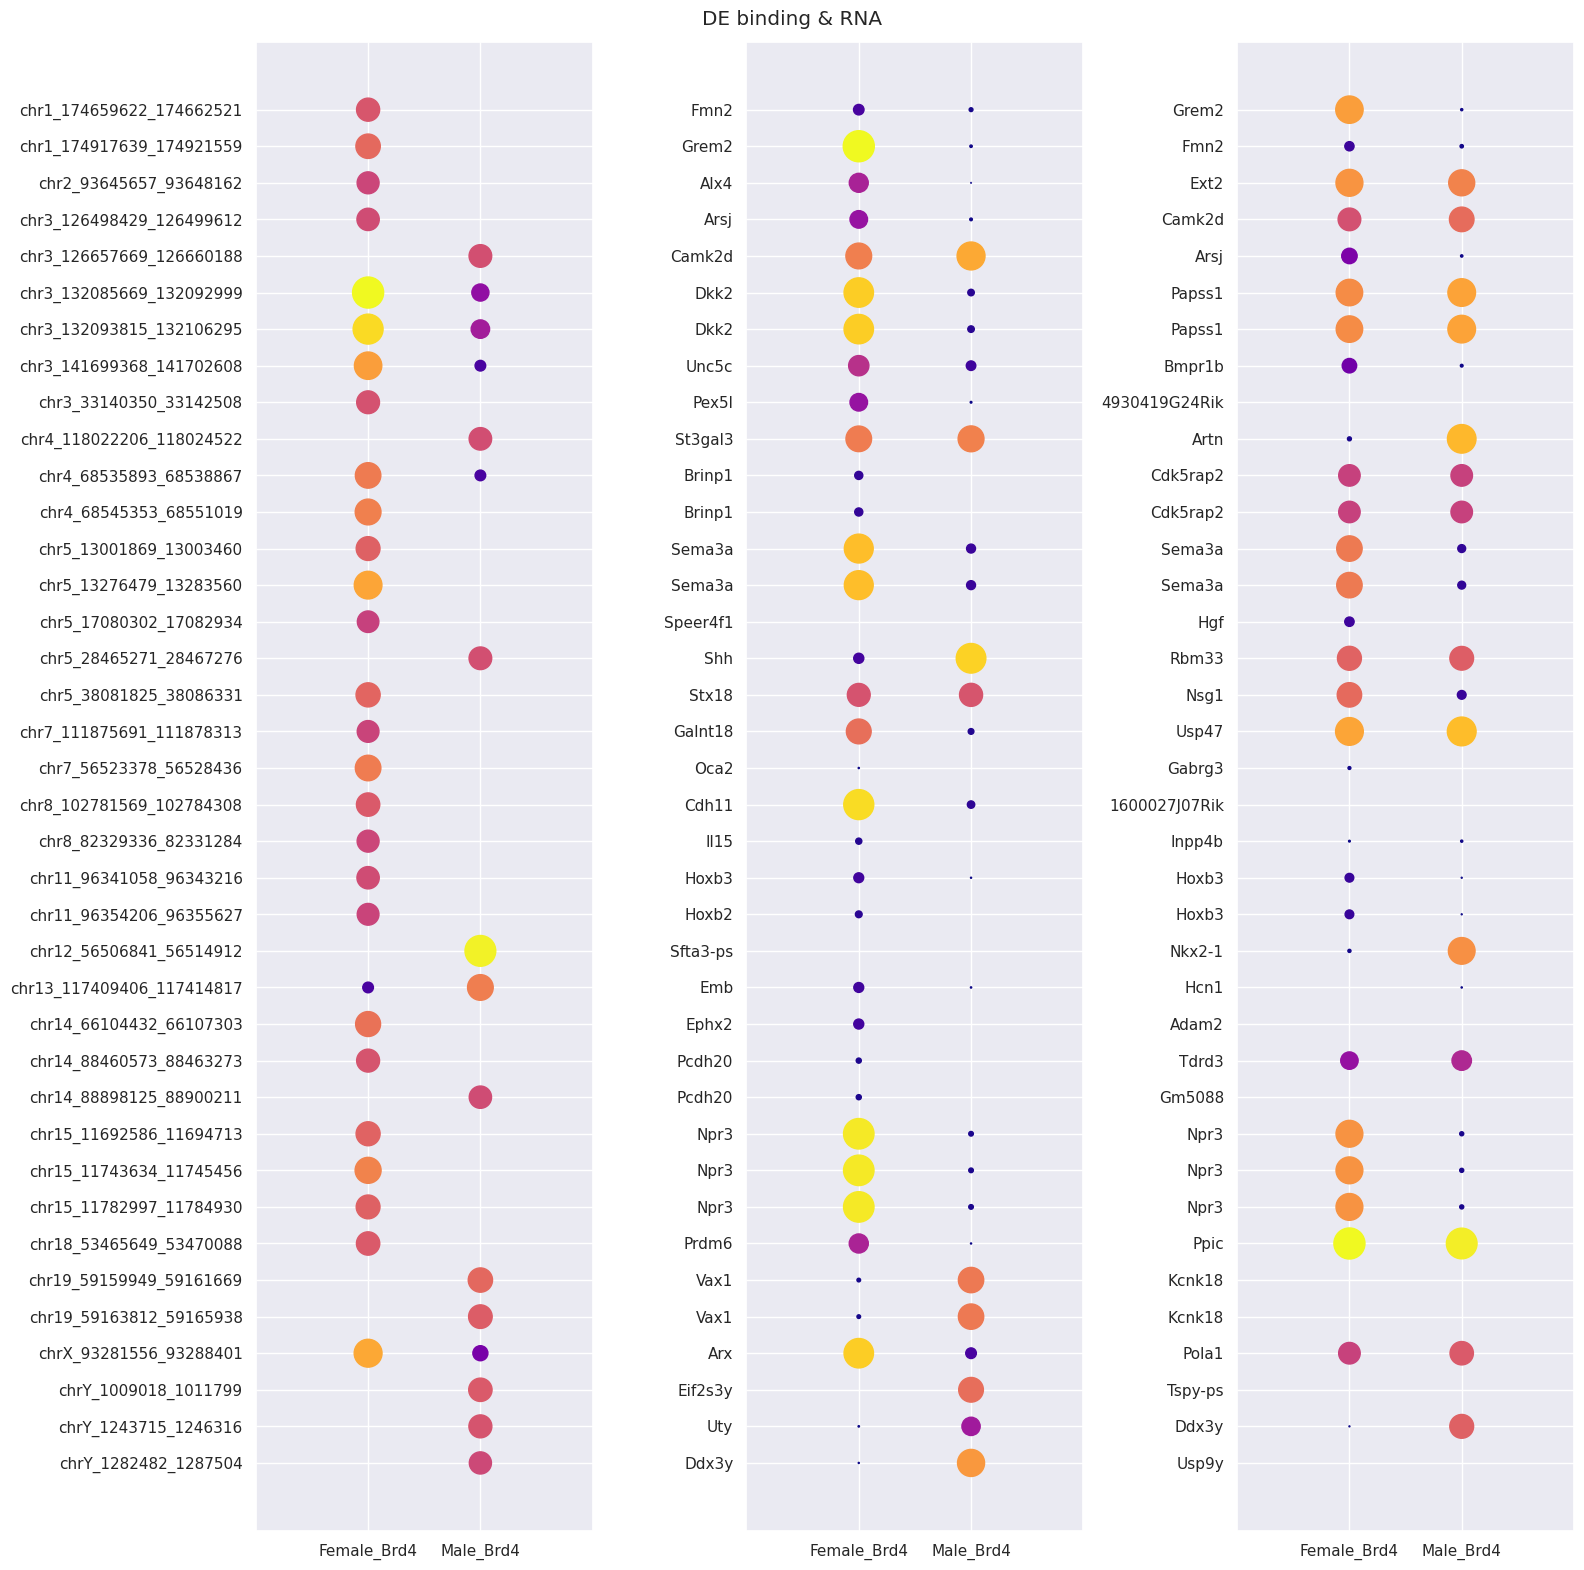

In [27]:
cc.pl.dotplot_bulk(adata_cc, rna, selected_list = list(np.unique(np.array(result["Peak"]))), num_list = [3,3], dotsize = 500,
                   cmap = 'plasma', figsize = (16, 16), sort_by_chrom = True, topspace = 0.96)

We can see from these results that all of the peaks visualized here display differential binding, and either the nearest, or second nearest gene has differential expression. In most cases, increased Brd4 binding is associated with an increase in gene expression. 

Pycallingcards provides functionality to explore relatinoships between differentially bound regions and nearby GWAS identified SNPs. Since the data analyzed here were collected in murine cells, we must first lift over any interesting peaks to the human genome before we can look for nearby disease associated SNPs. We use [liftover](https://genome.ucsc.edu/cgi-bin/hgLiftOver) to get the resuls.

In [28]:
result = cc.tl.result_mapping(result)
result

Start mapping the peaks to the new genome.


100%|██████████| 40/40 [00:00<00:00, 69.43it/s] 


Start finding location of genes in the new genome.


100%|██████████| 40/40 [00:00<00:00, 287.78it/s]


Peak  logfoldchanges_peak    Pvalue_peak  \
0    chr1_174659622_174662521             5.652435   1.530047e-08   
1    chr1_174917639_174921559             6.208699   2.711848e-12   
2      chr2_93645657_93648162             5.189615   2.360560e-06   
3      chr3_33140350_33142508             5.534632   6.455627e-08   
4    chr3_126498429_126499612             5.337659   5.594815e-07   
5    chr3_126657669_126660188            -5.397757   5.546104e-07   
6    chr3_132085669_132092999             6.121213  1.509244e-105   
7    chr3_132093815_132106295             5.072335   9.590057e-65   
8    chr3_141699368_141702608             6.065565   2.403341e-29   
9      chr4_68535893_68538867             5.172571   1.974087e-15   
10     chr4_68545353_68551019             6.825275   1.516093e-18   
11   chr4_118022206_118024522            -5.332271   1.094775e-06   
12     chr5_13001869_13003460             5.957213   2.037009e-10   
13     chr5_13276479_13283560             7.727895   3.536779e-34   
14     chr5_17080302_17082934             5.024623   9.959617e-06   
15     chr5_28465271_28467276            -5.397757   5.546104e-07   
16     chr5_38081825_38086331             6.088429   2.350343e-11   
17     chr7_56523378_56528436             6.721266   2.699280e-17   
18   chr7_111875691_111878313             5.109476   4.848742e-06   
19     chr8_82329336_82331284             5.189615   2.360560e-06   
20   chr8_102781569_102784308             5.761340   3.626346e-09   
21    chr11_96341058_96343216             5.337659   5.594815e-07   
22    chr11_96354206_96355627             5.109476   4.848742e-06   
23    chr11_96354206_96355627             5.109476   4.848742e-06   
24    chr12_56506841_56514912            -9.259195   2.083740e-95   
25  chr13_117409406_117414817            -5.127606   3.397970e-15   
26    chr14_66104432_66107303             6.455571   1.757505e-14   
27    chr14_88460573_88463273             5.594736   3.142836e-08   
28    chr14_88898125_88900211            -5.263671   2.162151e-06   
29    chr15_11692586_11694713             6.046002   4.827833e-11   
30    chr15_11743634_11745456             6.922288   8.515240e-20   
31    chr15_11782997_11784930             5.957213   2.037009e-10   
32    chr18_53465649_53470088             5.761340   3.626346e-09   
33    chr19_59159949_59161669            -6.094880   4.260481e-11   
34    chr19_59163812_59165938            -5.788022   4.812885e-09   
35     chrX_93281556_93288401             5.093695   9.655833e-32   
36       chrY_1009018_1011799            -5.686862   1.864054e-08   
37       chrY_1243715_1246316            -5.520433   1.425488e-07   
38       chrY_1243715_1246316            -5.520433   1.425488e-07   
39       chrY_1282482_1287504            -5.191646   4.272455e-06   

    Pvalue_adj_peak     Gene  Score_gene    Pvalue_gene  Pvalue_adj_gene  \
0      4.586591e-07    Grem2  -10.401831   1.280025e-67     1.252748e-65   
1      1.562878e-10    Grem2  -10.401831   1.280025e-67     1.252748e-65   
2      4.324934e-05     Alx4  -10.292504   5.458739e-18     1.081356e-16   
3      1.724615e-06    Pex5l   -7.590236   2.351122e-24     6.841972e-23   
4      1.202787e-05     Arsj   -6.281259   8.667831e-27     2.783525e-25   
5      1.202787e-05     Arsj   -6.281259   8.667831e-27     2.783525e-25   
6     2.850264e-102     Dkk2   -6.916087  9.389039e-178    5.513378e-175   
7      6.924867e-62     Dkk2   -6.916087  9.389039e-178    5.513378e-175   
8      5.413249e-27   Bmpr1b   -5.570116   6.893076e-40     3.655998e-38   
9      1.648497e-13   Brinp1   -7.758307   5.384595e-10     5.726618e-09   
10     1.684235e-16   Brinp1   -7.758307   5.384595e-10     5.726618e-09   
11     2.210347e-05     Artn    9.083650   8.043160e-84     1.066497e-81   
12     8.898685e-09   Sema3a   -5.771471  3.017136e-297    6.200968e-294   
13     1.033708e-31   Sema3a   -5.771471  3.017136e-297    6.200968e-294   
14     1.561421e-04      Hgf   -7.513756   2.543270e-09

In [29]:
GWAS_result = cc.tl.GWAS(result)
GWAS_result

Peak  logfoldchanges_peak    Pvalue_peak  \
0    chr1_174659622_174662521             5.652435   1.530047e-08   
1    chr1_174917639_174921559             6.208699   2.711848e-12   
2      chr2_93645657_93648162             5.189615   2.360560e-06   
3      chr3_33140350_33142508             5.534632   6.455627e-08   
4    chr3_126498429_126499612             5.337659   5.594815e-07   
5    chr3_126657669_126660188            -5.397757   5.546104e-07   
6    chr3_132085669_132092999             6.121213  1.509244e-105   
7    chr3_132093815_132106295             5.072335   9.590057e-65   
8    chr3_141699368_141702608             6.065565   2.403341e-29   
9      chr4_68535893_68538867             5.172571   1.974087e-15   
10     chr4_68545353_68551019             6.825275   1.516093e-18   
11   chr4_118022206_118024522            -5.332271   1.094775e-06   
12     chr5_13001869_13003460             5.957213   2.037009e-10   
13     chr5_13276479_13283560             7.727895   3.536779e-34   
14     chr5_17080302_17082934             5.024623   9.959617e-06   
15     chr5_28465271_28467276            -5.397757   5.546104e-07   
16     chr5_38081825_38086331             6.088429   2.350343e-11   
17     chr7_56523378_56528436             6.721266   2.699280e-17   
18   chr7_111875691_111878313             5.109476   4.848742e-06   
19     chr8_82329336_82331284             5.189615   2.360560e-06   
20   chr8_102781569_102784308             5.761340   3.626346e-09   
21    chr11_96341058_96343216             5.337659   5.594815e-07   
22    chr11_96354206_96355627             5.109476   4.848742e-06   
23    chr11_96354206_96355627             5.109476   4.848742e-06   
24    chr12_56506841_56514912            -9.259195   2.083740e-95   
25  chr13_117409406_117414817            -5.127606   3.397970e-15   
26    chr14_66104432_66107303             6.455571   1.757505e-14   
27    chr14_88460573_88463273             5.594736   3.142836e-08   
28    chr14_88898125_88900211            -5.263671   2.162151e-06   
29    chr15_11692586_11694713             6.046002   4.827833e-11   
30    chr15_11743634_11745456             6.922288   8.515240e-20   
31    chr15_11782997_11784930             5.957213   2.037009e-10   
32    chr18_53465649_53470088             5.761340   3.626346e-09   
33    chr19_59159949_59161669            -6.094880   4.260481e-11   
34    chr19_59163812_59165938            -5.788022   4.812885e-09   
35     chrX_93281556_93288401             5.093695   9.655833e-32   
36       chrY_1009018_1011799            -5.686862   1.864054e-08   
37       chrY_1243715_1246316            -5.520433   1.425488e-07   
38       chrY_1243715_1246316            -5.520433   1.425488e-07   
39       chrY_1282482_1287504            -5.191646   4.272455e-06   

    Pvalue_adj_peak     Gene  Score_gene    Pvalue_gene  Pvalue_adj_gene  \
0      4.586591e-07    Grem2  -10.401831   1.280025e-67     1.252748e-65   
1      1.562878e-10    Grem2  -10.401831   1.280025e-67     1.252748e-65   
2      4.324934e-05     Alx4  -10.292504   5.458739e-18     1.081356e-16   
3      1.724615e-06    Pex5l   -7.590236   2.351122e-24     6.841972e-23   
4      1.202787e-05     Arsj   -6.281259   8.667831e-27     2.783525e-25   
5      1.202787e-05     Arsj   -6.281259   8.667831e-27     2.783525e-25   
6     2.850264e-102     Dkk2   -6.916087  9.389039e-178    5.513378e-175   
7      6.924867e-62     Dkk2   -6.916087  9.389039e-178    5.513378e-175   
8      5.413249e-27   Bmpr1b   -5.570116   6.893076e-40     3.655998e-38   
9      1.648497e-13   Brinp1   -7.758307   5.384595e-10     5.726618e-09   
10     1.684235e-16   Brinp1   -7.758307   5.384595e-10     5.726618e-09   
11     2.210347e-05     Artn    9.083650   8.043160e-84     1.066497e-81   
12     8.898685e-09   Sema3a   -5.771471  3.017136e-297    6.200968e-294   
13     1.033708e-31   Sema3a   -5.771471  3.017136e-297    6.200968e-294   
14     1.561421e-04      Hgf   -7.513756   2.543270e-09

Save the file if needed.

In [30]:
adata_cc.write("Brd4_bindings_bulk.h5ad")